![Rearc](../rearc_logo_rgb.png)

 ## Demo: EDGAR Company Filing Dataset - Form Type 10-K | SEC

This dataset contains the quarterly reports of all company filings of form "10-K" since 1993. [Check it out](https://aws.amazon.com/marketplace/pp/prodview-k65p3l3pdyqfw?qid=1622601179293&sr=0-1&ref_=srh_res_product_title) on the Amazon Data Exchange marketplace.

Form 10-K is filed annually by public companies, and provides overall financial information and outlook for the company, including cashflows, balances, liabilities, perceived business risks, and more.

To download this file-based data product through the AWS Data Exchange Marketplace, you must subscribe to the product. For details, refer to [Subscribing to Data Products](https://docs.aws.amazon.com/data-exchange/latest/userguide/subscribe-to-data-sets.html) on AWS Data Exchange in the AWS Data Exchange User Guide.

After subscribing to the product, you can use this notebook to export the dataset revisions and explore the data. This dataset contains the 10-K forms submitted to SEC as provided by the EDGAR portal. All files are in .txt format.

## Dataset Directory Structure

After you exported the revisions, if you navigate to the S3 bucket you specified above to export the data, you will find the dataset structured as following:
```
dataset/
├── 2020/
│  ├── Q1/
│  │  ├── file1.txt 
│  │  ├── file2.txt 
│  │  └── ...
│  ├── Q2/
│  ├── Q3/
│  └── Q4/
│ 
├── 2019/
│  ├── Q1/
│  └── ... 
│ 
├── ...
│ 
└── 1993/
   └── ...
```

## Extract financial tables for sections 6, 7 from a 10-K form

In [1]:
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
import collections
pd.options.plotting.backend = "matplotlib"


In [2]:
dataset_path = "EDGAR-Company-Filing-Dataset-Form-Type-10K-SEC/c26c517bea98245dc7a949484f4cac5a/edgar/edgar_company_filings_form_10_K"

data_dir = os.path.join(
    os.getcwd(), 
    dataset_path,
    'dataset/2020/QTR4'
)

file_name = "1385157-0001558370-20-013511.txt"

files = [f for f in os.listdir(data_dir) if str(f) == file_name]
data = None

for f in files:
    with open(os.path.join(data_dir, f)) as reader:
        data = reader.read()
    break

raw_10k = data

In [3]:
print(raw_10k[0:1066])

<SEC-DOCUMENT>0001558370-20-013511.txt : 20201110
<SEC-HEADER>0001558370-20-013511.hdr.sgml : 20201110
<ACCEPTANCE-DATETIME>20201110152800
ACCESSION NUMBER:		0001558370-20-013511
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		133
CONFORMED PERIOD OF REPORT:	20200925
FILED AS OF DATE:		20201110
DATE AS OF CHANGE:		20201110

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			TE Connectivity Ltd.
		CENTRAL INDEX KEY:			0001385157
		STANDARD INDUSTRIAL CLASSIFICATION:	WHOLESALE-ELECTRONIC PARTS & EQUIPMENT, NEC [5065]
		IRS NUMBER:				980518048
		STATE OF INCORPORATION:			V8
		FISCAL YEAR END:			0925

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-33260
		FILM NUMBER:		201300918

	BUSINESS ADDRESS:	
		STREET 1:		MUHLENSTRASSE 26
		CITY:			SCHAFFHAUSEN
		STATE:			V8
		ZIP:			CH-8200
		BUSINESS PHONE:		41 (0)52 633 6661

	MAIL ADDRESS:	
		STREET 1:		MUHLENSTRASSE 26
		CITY:			SCHAFFHAUSEN
		STATE:			V8
		ZIP:			CH-8200

	FORMER COMPANY:	
		FORMER CON

In [4]:
# Regex to find <DOCUMENT> tags
doc_start_pattern = re.compile(r'<DOCUMENT>')
doc_start_is = doc_start_pattern.finditer(raw_10k)

doc_end_pattern = re.compile(r'</DOCUMENT>')
doc_end_is = doc_end_pattern.finditer(raw_10k)

# Regex to find <TYPE> tag prceeding any characters, terminating at new line
type_pattern = re.compile(r'(<TYPE>)([^\n]+)')
doc_types = type_pattern.finditer(raw_10k)

document = {}

# Create a loop to go through each section type and save documents in the dictionary
for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
    doc_type = doc_type[2]
    document[doc_type] = raw_10k[doc_start.end():doc_end.start()]

In [5]:
pd.DataFrame({"Document Name":document.keys()})

,Document Name
0,10-K
1,EX-4.1
2,EX-10.3
3,EX-10.8
4,EX-10.12
5,EX-10.17
6,EX-10.29
7,EX-21.1
8,EX-22.1
9,EX-23.1


In [26]:


html_start = re.search(r"<\?xml", document["10-K"]).start()


from urllib.request import urlopen
from bs4 import BeautifulSoup

html = document["10-K"][html_start:]
soup = BeautifulSoup(html, features="html.parser")

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text(" ")
path = "out.txt"
with open(path, "w") as fh:
    for ix, line in enumerate(text.splitlines()):
        line = line.strip()
        chunks = []
        for phrase in line.split("    "):
            phrase = phrase.replace("Table of Contents", "").strip()
            if phrase != "":
                chunks.append(phrase.strip())
        line_text = ' '.join(chunks)
        if line_text.strip() != "":
            fh.write(line_text + "\n")
# # break into lines and remove leading and trailing space on each
# lines = (line.strip() for line in text.splitlines())
# # break multi-headlines into a line each
# chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# # drop blank lines
# text = '\n'.join(chunk for chunk in chunks if chunk)

# for ix, line in enumerate(text.splitlines()):
#     if ix != 0:
#         print(ix, "\n",line)

# # print(text)

## Text Analytics on Form Content
.


.

.

.

.

..


In [9]:
html_start = re.search(r"<\?xml", document["10-K"]).start()

soup = BeautifulSoup(document["10-K"][html_start:], 'lxml')

In [10]:
# Get text 
doc_text = ''
for node in soup.findAll('p'):
    doc_text += ''.join(node.findAll(text=True))

<AxesSubplot:xlabel='Bi-Gram'>

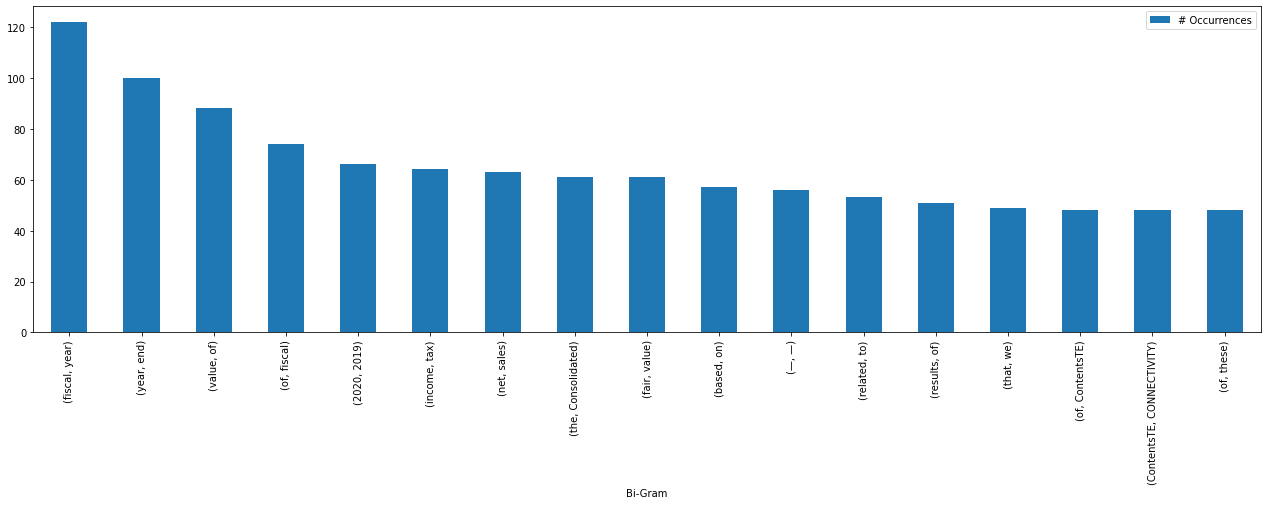

In [11]:
from nltk.util import ngrams # function for making ngrams

doc_text = re.sub(r"^a-zA-Z\d\s", " ", doc_text)
doc_text = re.sub(r"  +", " ", doc_text)


tokenized_text = doc_text.split()
# and get a list of all the bi-grams
bigrams = ngrams(tokenized_text, 2)

# get the frequency of each bigram in our corpus
bigramFreq = collections.Counter(bigrams)
common_bigrams = bigramFreq.most_common(30)

# Top 20 bigrams without filler words
filler_words = ["the", "of", "a", "to", "be", "in", "our", "table", "on", "and", "as", "other", "for", "with", "-"]
results = pd.DataFrame(filter(lambda x: True if x[0][0] not in filler_words or x[0][1] not in filler_words else False, common_bigrams))
results.columns = ["Bi-Gram", "# Occurrences"]
results.set_index("Bi-Gram", inplace=True)

results.plot(y="# Occurrences", kind='bar', figsize=(22,6))

## Apply REGEX to find Sections 6 and 7 under 10-K Section 

The items in this `document` can be found in four different patterns. The specified regex patterns accounts for various formats that a section title may appear in the document.

In [89]:
regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)([1-9])([0-9]){0,1}[AB]{0,1}\.{0,1})|(ITEM\s{0,1}(&#160;|&nbsp;){0,1}([1-9])([0-9]){0,1}[AB]{0,1}\.{0,1})')

matches = regex.finditer(document['10-K'])


In [90]:
# Matches
matches = regex.finditer(document['10-K'])

# Create the dataframe
test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

test_df.columns = ['item', 'start', 'end']
test_df['item'] = test_df.item.str.lower()

# Get rid of unnesesary charcters from the dataframe
test_df.replace('&#160;',' ',regex=True,inplace=True)
test_df.replace('&nbsp;',' ',regex=True,inplace=True)
test_df.replace(' ','',regex=True,inplace=True)
test_df.replace('\.','',regex=True,inplace=True)
test_df.replace('>','',regex=True,inplace=True)

# Drop duplicates and only keep the last appearance of each section
pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')

# Set item as the dataframe index
pos_dat.set_index('item', inplace=True)

# Display the dataframe
test_df.head(20)

,item,start,end
0,item1b,364670,364676
1,item1,364837,364850
2,item1b,365061,365067
3,item1a,365675,365681
4,item1a,365846,365860
5,item1a,366071,366077
6,item1b,366858,366867
7,item2,367708,367713
8,item2,367877,367890
9,item2,368101,368106


In [91]:
# Get desired sections
item_6_raw = document['10-K'][pos_dat['start'].loc['item6']:pos_dat['start'].loc['item7']]   
item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]   

# Convert the raw text we have to exrtacted to BeautifulSoup object 
item_6_content = BeautifulSoup(item_6_raw, 'lxml')
item_7_content = BeautifulSoup(item_7_raw, 'lxml')

In [92]:
tables_6 = item_6_content.find_all('table')
tables_7 = item_7_content.find_all('table')

## Financial Data Summary from Section 6

In [93]:
from IPython.core.display import display, HTML

for item in tables_6:
    display(HTML(item.prettify()))

(1),Fiscal 2016 was a 53-week year.


(2),Fiscal 2016 included a pre-tax gain of $144 million on the sale of our Circuit Protection Devices business.


(3),Fiscal 2020 included a goodwill impairment charge related to the Sensors reporting unit in our Transportation Solutions segment. See Note 8 to the Consolidated Financial Statements for additional information regarding the impairment of goodwill.


(4),Fiscal 2016 net other income (expense) was recorded primarily pursuant to the Tax Sharing Agreement with Tyco International plc and Covidien plc and included $604 million of other expense related to the effective settlement of tax matters for the years 1997 through 2000 and $46 million of other expense related to a tax settlement in another tax jurisdiction.


(5),"For fiscal 2020, 2019, and 2018, see Note 16 to the Consolidated Financial Statements for additional information. Fiscal 2016 included a $1,135 million income tax benefit related to the effective settlement of tax matters for the years 1997 through 2000, partially offset by a $91 million income tax charge related to an increase to the valuation allowance for certain U.S. deferred tax assets. Additionally, fiscal 2016 included an $83 million net income tax benefit related to tax settlements in certain other tax jurisdictions, partially offset by an income tax charge related to certain legal entity restructurings."


(6),"Fiscal 2019 included a pre-tax loss of $86 million on the sale of our Subsea Communications business. For additional information regarding discontinued operations, see Note 4 to the Consolidated Financial Statements."


## Financial Tables of Section 7

### Products and Services

In [244]:
products = tables_7[12]
display(HTML(products.prettify()))

### Changes in Net Sales in Fiscal Year 2020 vs Fiscal Year 2019

In [245]:
product_changes = tables_7[13]
display(HTML(product_changes.prettify()))

### 

In [246]:
tables = tables_7[19:22]
for table in tables:
    display(HTML(table.prettify()))

## Extracting Numerical Data From Financial Summary Table in Section 6 in a  DataFrame

In [283]:
digits = [str(x) for x in range(10)]

rows = []
titles = []
row_number = -1
prev = 0

for item in tables_6:
    ii = item.find_all('td')
    for iii in ii:
        txt = iii.get_text().replace("\n",'').replace("\t",'').replace('​','')
        if txt:
            ll = txt.strip().split('\n')
            for l in ll:
                l = l.strip()
                if l and l != '$':
                    if l[0] in digits or (l[0] == '(' and l[1] in digits) or l.startswith('—'):
                        rows[row_number].append(l)
                        prev = 0
                    else:
                        if not prev:
                            row_number += 1
                            rows.append([])
                            titles.append(l)
                        else:
                            titles[-1] = titles[-1] + ' ' + l
                        prev = 1
    break

In [290]:
for ri, row in enumerate(rows):
    for si, s in enumerate(row):
        ss = s.replace(',', '')
        if ss.startswith('('):
            ss = '-' + ss[1:-1]       
            rows[ri][si] = ss


In [291]:
table_rows = [ [titles[i]] + rows[i] for i in range(len(titles))]
tables_df = pd.DataFrame(table_rows).set_index(0)

tables_df

,1,2,3,4,5
0,,,,,
As of or for Fiscal,2020,2019,2018,2017,2016(1)
"(in millions, except per share data) Statement of Operations Data Net sales","12,172","13,448","13,988","12,185","11,352"
Acquisition and integration costs,36,27,14,6,22
"Restructuring and other charges (credits), net(2)",257,255,126,147,-2
Impairment of goodwill(3),900,—,—,—,—
"Other income (expense), net(4)",20,2,1,-42,-677
Income tax (expense) benefit(5),-783,15,344,-180,826
Income (loss) from continuing operations,-259,"1,946","2,584","1,540","1,847"
"Income (loss) from discontinued operations, net of income taxes(6)",18,-102,-19,143,162
